**Reinforcement Learning with TensorFlow & TRFL: Policy Entropy Loss**

Outline:
1. Introduce Policy Entropy Loss
* Discrete Policy Entropy Loss with TRFL
* Continuous Policy Entropy Loss with TRFL




In [0]:
#TRFL works with TensorFlow 1.12
#installs TensorFlow version 1.12 then restarts the runtime
!pip install tensorflow==1.12

import os
os.kill(os.getpid(), 9)

In [1]:
#install tensorflow-probability 0.5.0 that works with TensorFlow 1.12
!pip install tensorflow-probability==0.5.0

#install TRFL
!pip install trfl==1.0

#install box2d for LunarLanding env
!pip install box2d-py


In [0]:
import gym
import tensorflow as tf
import trfl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

** Policy Entropy Loss **

Policy entropy loss can be combined with other loss functions, such as the trfl.policy_gradient_loss() that we went over last video, to improve policies. In TRFL entropy loss can be called as a stand alone function, like we’ll show in this video when we add it to policy gradient loss. Entropy loss can also be built into other loss functions like TRFL’s actor critic loss functions where entropy is an optional parameter, which we’ll see next video.

The key point to remember is that entropy is maximized when action probabilities are equally likely and minimized when one action completely dominates. Like in gridworld if an agent took one of four actions at random, policy entropy would be maximized, while if the agent always took one action policy entropy would be minimized. Note how the formula takes the negative. When we add, the negative number to our other losses and minimize the losses, we are encouraging action probabilities to be more uniform. Ie the more uniform the policies the higher the entropy is. The higher the entropy is, the larger the negative number we add to the loss and thus the more the loss is minimized.


** Example 1: Discrete Policy Entropy Loss with Lunar Lander **

In [0]:
# set up policy network

class PolicyNetwork:
  def __init__(self, name, learning_rate=0.001, obs_size=2, action_size=3, hidden_size=64, entropy_coefficient=0.01):
    
    with tf.variable_scope(name):
      self.name=name
      # set up placeholders
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.action_ = tf.placeholder(tf.int32, [None], name='action')
      self.value_ = tf.placeholder(tf.float32, [None], name='values')
      
      # set up policy network
      self.fc1_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.leaky_relu)
      self.fc2_ = tf.contrib.layers.fully_connected(self.fc1_, hidden_size, activation_fn=tf.nn.leaky_relu)
      self.fc3_ = tf.contrib.layers.fully_connected(self.fc2_, action_size, activation_fn=None)

      # generate action probabilities for taking actions
      self.action_prob_ = tf.nn.softmax(self.fc3_)
      
      # TRFL usage
      self.pg_loss_ = trfl.discrete_policy_gradient(self.fc3_, self.action_, self.value_) 
      self.entropy_loss_, _ = trfl.discrete_policy_entropy_loss(self.fc3_, normalise=True)
      self.combined_loss_ = self.pg_loss_ + entropy_coefficient * self.entropy_loss_
      # Optimize the loss
      self.loss_ = tf.reduce_mean(self.combined_loss_)
      self.optim_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_)
      

** TRFL Usage **

TRFL usage is nearly identical to the code from the last example. Note the additional entropy loss is added to the PG loss.



In [0]:
# hyperparameters
train_episodes = 5000                     
discount = 0.99     

hidden_size = 32
learning_rate = 0.003
entropy_coefficient = 0.0001

seed = 31
env = gym.make('LunarLander-v2')
env.seed(seed)
np.random.seed(seed)

action_size = env.action_space.n
obs_size = env.observation_space.shape[0]

tf.reset_default_graph()
tf.set_random_seed(seed)
# Create policy network
policy_net = PolicyNetwork(name='policy_net', hidden_size=hidden_size, obs_size=obs_size,
                          action_size=action_size, learning_rate=learning_rate, entropy_coefficient=entropy_coefficient)


In [0]:
# TRFL Usage: scan_discounted_sum
seq_ = tf.placeholder(dtype=tf.float32)
disc_seq_ = tf.placeholder(dtype=tf.float32)
init_value_ = tf.placeholder(dtype=tf.float32)
scan_disc_sum_ = trfl.scan_discounted_sum(seq_, disc_seq_, init_value_,reverse=True)

In [21]:
stats_rewards_list = []

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    for ep in range(1, train_episodes):
        total_reward = 0
        ep_length = 0
        state = env.reset() 
        state = np.clip(state,-1.0,1.0) #clip state within useful range of values
        done = 0
        
        # store trajectories in lists, when episode is done use trajectories to train agents
        obs_list, rew_list, action_list = [], [], []
        
        # stop episodes when agent is able to solve game
        if len(stats_rewards_list) > 10 and np.mean(stats_rewards_list[-10:],axis=0)[1] > 200:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(stats_rewards_list[-10:],axis=0)[1]))
          break
          
        while not done:
            # generate action probabilities from policy net and sample from the action probs
            action_probs = sess.run(policy_net.action_prob_, feed_dict={policy_net.input_: np.expand_dims(state,axis=0)})
            action_probs = action_probs[0]
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            obs_list.append(state)
            action_list.append(action)
            
            state, reward, done, info = env.step(action)
            total_reward += reward
            state = np.clip(state,-1.0,1.0)
            # scale rewards
            reward *= .01
            
            rew_list.append(reward)
            ep_length += 1
            
            if total_reward < -250:
              done = 1
              
            if done:
              # get reward values placeholder to multipy log probs
              # collect rewards until episode is over, then discount over trajectory by using trfl.scan_discounted_sum
              discount_array = np.array([discount]*len(rew_list))
              values = sess.run(scan_disc_sum_, feed_dict={seq_:np.array(rew_list, dtype=np.float32), 
                                                            disc_seq_:discount_array, init_value_:np.array([0.])})
              
              # clip reward trajectory
              scaled_values = np.clip(values,-5.,5.)
              
              # train policy on collected trajectories
              _, stats_loss = sess.run([policy_net.optim_, policy_net.loss_], 
                                       feed_dict={ policy_net.input_: np.array(obs_list),
                                                 policy_net.action_: np.array(action_list,dtype=np.int32),
                                                 policy_net.value_: np.squeeze(scaled_values)} )

              if ep % 10 == 0:
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Ep length: {}'.format(ep_length),
                      'Training loss: {:.4f}'.format(stats_loss))
              stats_rewards_list.append((ep, total_reward))
                
              break
         

Episode: 10 Total reward: -268.1882327475088 Ep length: 117 Training loss: -1.6434
Episode: 20 Total reward: -276.6274657122255 Ep length: 71 Training loss: -2.1937
Episode: 30 Total reward: -346.57897956769534 Ep length: 134 Training loss: -2.2309
Episode: 40 Total reward: -256.52498341679126 Ep length: 72 Training loss: -1.5057
Episode: 50 Total reward: -231.0410704879979 Ep length: 99 Training loss: -1.3239
Episode: 60 Total reward: -64.7122236892726 Ep length: 88 Training loss: -0.5839
Episode: 70 Total reward: -247.02572617596562 Ep length: 136 Training loss: -1.3828
Episode: 80 Total reward: -155.6282663644171 Ep length: 138 Training loss: -1.0229
Episode: 90 Total reward: -98.74138268892912 Ep length: 76 Training loss: -0.8850
Episode: 100 Total reward: -58.7260435620874 Ep length: 75 Training loss: -0.5035
Episode: 110 Total reward: -108.76695111121097 Ep length: 124 Training loss: -0.7257
Episode: 120 Total reward: -137.37596043371846 Ep length: 115 Training loss: -0.8028
Epis

Text(0, 0.5, 'Total Reward')

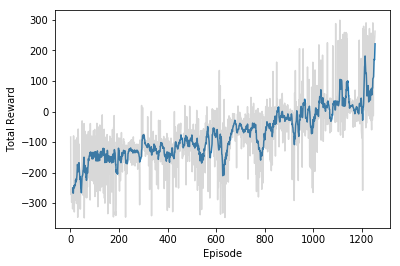

In [22]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(stats_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

** Example 2: Continuous Policy Entropy Loss **

In [0]:
# set up policy network

class PolicyNetwork:
  def __init__(self, name, learning_rate=0.001, obs_size=2, action_size=3, hidden_size=64,action_low=-1.,action_high=1.,
              entropy_coefficient=0.005):
    
    with tf.variable_scope(name):
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.action_ = tf.placeholder(tf.float32, [None,action_size], name='action')
      self.value_ = tf.placeholder(tf.float32, [None,], name='values')
      self.name=name
      
      # set up loc network
      self.fc1_mu_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.elu)
      self.fc2_mu_ = tf.contrib.layers.fully_connected(self.fc1_mu_, hidden_size, activation_fn=tf.nn.elu)
      self.fc3_mu_ = tf.contrib.layers.fully_connected(self.fc2_mu_, action_size, activation_fn=tf.nn.tanh)
      
      # set up scale network
      self.fc1_scale_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.elu)
      self.fc2_scale_ = tf.contrib.layers.fully_connected(self.fc1_scale_, hidden_size, activation_fn=tf.nn.elu)
      self.fc3_scale_ = tf.contrib.layers.fully_connected(self.fc2_scale_, action_size, activation_fn=tf.nn.sigmoid)
      self.scale_ = self.fc3_scale_*.25 + 1e-5 #must be > 0 hence the small constant and tf.nn.softplus
      
      # policy distribution that we parameterize in the continuous case
      self.distribution_ = tfp.distributions.MultivariateNormalDiag(loc=self.fc3_mu_, scale_diag=self.scale_)

      # generate actions by sampling from distributions and clipping them
      self.actions_scaled_ = tf.clip_by_value(self.distribution_.sample(), action_low, action_high) 
      
      # TRFL usage
      self.pg_loss_ = trfl.policy_gradient(self.distribution_, self.action_, self.value_)
      # Get the entropy loss and add it to the pg loss
      self.entropy_loss_, _ = trfl.policy_entropy_loss(self.distribution_)
      self.combined_loss_ = self.pg_loss_ + entropy_coefficient * self.entropy_loss_
      
      # optimizing the loss
      self.loss_ = tf.reduce_mean(self.combined_loss_)
      self.optim_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_)
      
      
# Value Function Network to produce baseline estimate. Reduces variance from prior REINFORCE method.
class ValueNetwork:
  def __init__(self, name, learning_rate=0.001, obs_size=2, hidden_size=64):
    
    with tf.variable_scope(name):
      self.name=name
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.target_ = tf.placeholder(tf.float32, [None,1], name='targets')
      
      #set up value network
      self.fc1_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.elu)
      self.fc2_ = tf.contrib.layers.fully_connected(self.fc1_, hidden_size, activation_fn=tf.nn.elu)
      self.fc3_ = tf.contrib.layers.fully_connected(self.fc2_, 1, activation_fn=None)
      
      # optimizing the loss
      self.loss_ = tf.losses.mean_squared_error(self.fc3_, self.target_)
      self.optim_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_)

** TRFL Usage **

Usage for continuous action spaces for trfl.policy_gradient is similar to the discrete case. The main difference is the first argument is a policy distribution in the continuous case. We parameterize the policy distribution with two neural networks whose outputs become inputs for the policy distribution. Note how the tensor placeholder for actions is now a float in this case as the actions are continuous.



In [24]:
# hyperparameters
train_episodes = 10000                     
discount = 0.99   

hidden_size = 64
policy_learning_rate = 0.002
value_learning_rate = 0.02
entropy_coefficient = 0.005
seed = 31
env = gym.make('LunarLanderContinuous-v2')

env.seed(seed)
np.random.seed(seed)
action_size = env.action_space.shape[0]
obs_size = env.observation_space.shape[0]

tf.reset_default_graph()
tf.set_random_seed(seed)
policy_net = PolicyNetwork(name='policy_net', hidden_size=hidden_size, obs_size=obs_size,
                          action_size=action_size, learning_rate=policy_learning_rate, action_low=env.action_space.low[0],
                          action_high=env.action_space.high[0], entropy_coefficient=entropy_coefficient)
value_net = ValueNetwork(name='value_net', hidden_size=hidden_size, obs_size=obs_size, learning_rate=value_learning_rate)

/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item()

In [0]:
#scan_discounted_sum
seq_ = tf.placeholder(dtype=tf.float32)
disc_seq_ = tf.placeholder(dtype=tf.float32)
init_value_ = tf.placeholder(dtype=tf.float32)
scan_disc_sum_ = trfl.scan_discounted_sum(seq_, disc_seq_, init_value_,reverse=True)

In [26]:
stats_rewards_list = []

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    for ep in range(1, train_episodes):
        total_reward = 0
        ep_length = 0
        state = np.clip(env.reset(),-1.,1.) 
        done = 0
        obs_list, rew_list, action_list = [],[],[]

        # stop early when env is solved
        if len(stats_rewards_list) > 10 and np.mean(stats_rewards_list[-10:],axis=0)[1] > 200:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(stats_rewards_list[-10:],axis=0)[1]))
          break
          
        while not done:
            action = sess.run(policy_net.actions_scaled_,feed_dict={policy_net.input_: np.expand_dims(state,axis=0)})
            action = action[0]  

            obs_list.append(state)
            action_list.append(action)
    
            state, reward, done, info = env.step(action)
            total_reward += reward
            reward *= .1
            state = np.clip(state,-1., 1.)
            rew_list.append(reward)
            
            total_reward += reward
            ep_length += 1
              
            if total_reward < -250:
              done = 1

            if done:
              # get reward values placeholder to multipy log probs by using trfl.scan_discounted_sum
              discount_array = np.array([discount]*len(rew_list))
              values = sess.run(scan_disc_sum_,feed_dict={seq_:np.array(rew_list, dtype=np.float32), 
                                                            disc_seq_:discount_array, init_value_:np.array([0.])})
              
              # run value network to get baseline predictions
              baselines = sess.run(value_net.fc3_, feed_dict={
                  value_net.input_:np.array(obs_list),
              })
              
              # advantage of returns over baselines
              advantage = values - baselines
              
              # train value network with reward trajectories
              value_loss, _ = sess.run([value_net.loss_, value_net.optim_], feed_dict={
                  value_net.input_:np.array(obs_list),
                  value_net.target_:values
              })

              # train policy on collected trajectories, use advantage to reduce variance
              _, stats_loss = sess.run([policy_net.optim_, policy_net.loss_], 
                                     feed_dict={ policy_net.input_: np.array(obs_list),
                                               policy_net.action_: np.array(action_list),
                                               policy_net.value_: np.squeeze(advantage)})
              
              if ep % 10 == 0:
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Ep length: {}'.format(ep_length),
                      'Training loss: {:.4f}'.format(stats_loss),
                      'Action means: {}'.format(np.mean(np.array(action_list),axis=0) ))
              stats_rewards_list.append((ep, total_reward))
              break

Episode: 10 Total reward: -253.57308408551594 Ep length: 88 Training loss: -4.7914 Action means: [ 0.48694763 -0.10304736]
Episode: 20 Total reward: -251.8200551280284 Ep length: 107 Training loss: 11.8108 Action means: [ 0.9142881  -0.03049557]
Episode: 30 Total reward: -251.26068756979927 Ep length: 45 Training loss: -0.7603 Action means: [0.94197667 0.1452094 ]
Episode: 40 Total reward: -251.43410142448195 Ep length: 84 Training loss: -3.0194 Action means: [0.9297914  0.03556389]
Episode: 50 Total reward: -235.9122301489981 Ep length: 166 Training loss: -4.5805 Action means: [0.0685885  0.02576823]
Episode: 60 Total reward: -185.53728512216398 Ep length: 59 Training loss: 0.3241 Action means: [-0.4741146  -0.02130498]
Episode: 70 Total reward: -189.08466749012482 Ep length: 100 Training loss: 2.7989 Action means: [-0.33834878  0.11976853]
Episode: 80 Total reward: -265.55622235727446 Ep length: 176 Training loss: -1.3079 Action means: [0.03007684 0.01431746]
Episode: 90 Total reward

Text(0, 0.5, 'Total Reward')

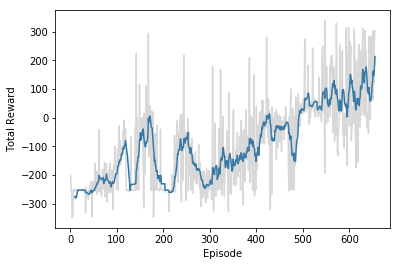

In [27]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(stats_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')